In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

(np.float64(-0.5), np.float64(749.5), np.float64(999.5), np.float64(-0.5))

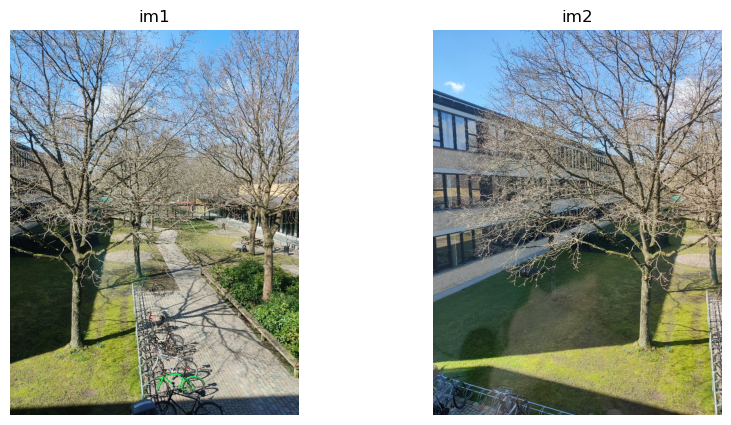

In [21]:
im1 = cv2.imread("images/im1.jpg")
im2 = cv2.imread("images/im2.jpg")
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
axes[0].set_title("im1")
axes[0].axis("off")
axes[1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))
axes[1].set_title("im2")
axes[1].axis("off")

## Ex 10.1

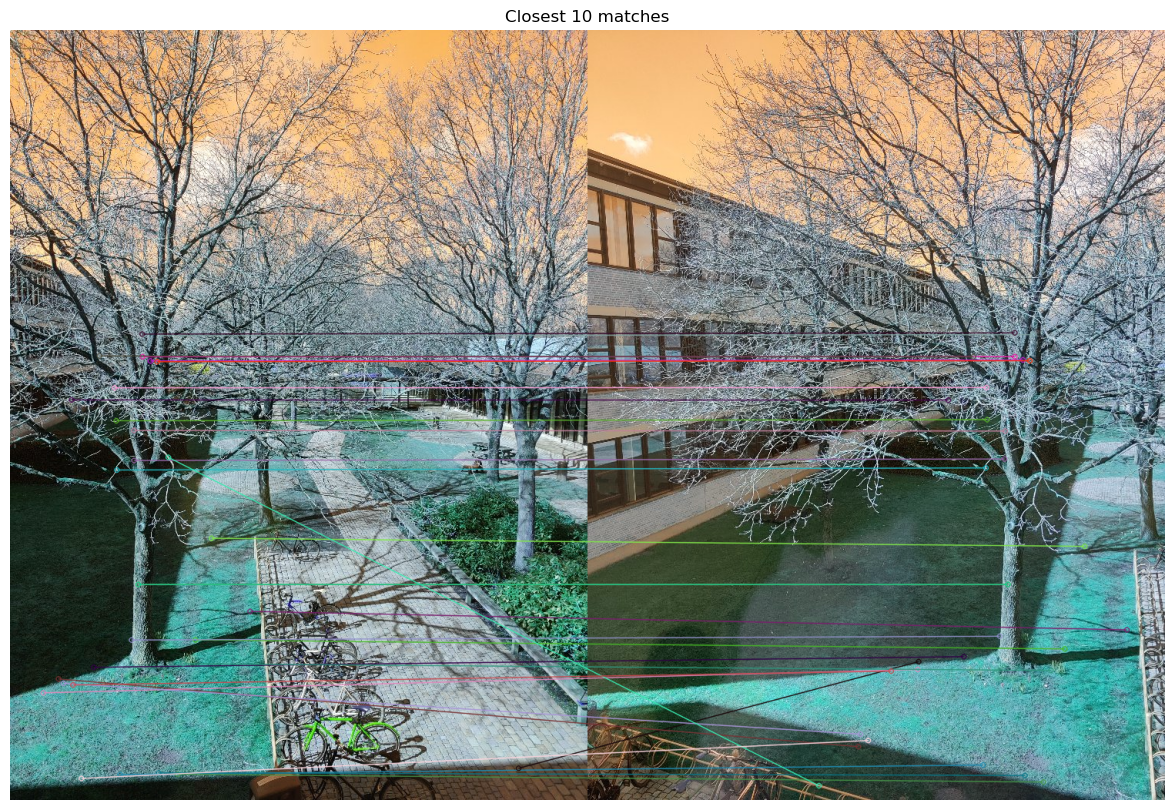

Number of matches: 2400


In [22]:
# Alernative
def find_features(im1, im2, plot=False):
    """
    Find matching features between two images.

    Args:
        im1 (np.ndarray): The first image.
        im2 (np.ndarray): The second image.

    Returns:
        matches (list): Matching features (cv2.DMatch objects).
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
    """
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # ascending

    # Draw first 10 matches.
    if plot:
        img3 = cv2.drawMatches(
            im1,
            kp1,
            im2,
            kp2,
            matches[:30],
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        mpl.rcParams["figure.figsize"] = [15, 10]
        plt.imshow(img3)
        plt.axis("off")
        plt.title("Closest 10 matches")
        plt.show()
        mpl.rcParams["figure.figsize"] = [8, 6]

    return matches, kp1, kp2


# Feature matching is correct when the connecting lines are mostly parallel.
matches, kp1, kp2 = find_features(im1, im2, plot=True)
print(f"Number of matches: {len(matches)}")

In [23]:
matches, kp1, kp2 = find_features(im1, im2)
im1_matches = np.array(
    [(kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1]) for m in matches]
)
im2_matches = np.array(
    [(kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1]) for m in matches]
)

im1_matches.shape

(2400, 2)

## Ex 10.2
Implement a RANSAC algorithm for finding the homography between im1 and im2.
What is the minimum number of matches you need to estimate a homography? (Tip: it’s four)
Explain why this is the case.
Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography.
Assume σ = 3 and use the formulas from the lecture last week to determine the threshold for when
a match should be considered an inlier.
While best practice would be to determine the number of iterations while running the algorithm,
you can fix it to i.e. 200.
To verify that the inliers of the best model are reasonable, visualize them. Consider using the
following code:
plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))
On the provided images you should find in the ballpark of a thousand inliers.

In [24]:
import sys
import os

# Get the absolute path to the parent directory containing "02504 Computer Vision"
parent_dir = os.path.abspath(os.path.join("../..", "02504-Computer-Vision"))

# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utility import Pi, Piinv, skew

In [25]:
def _hest(q1: np.array, q2: np.array):
    """
    Obtains estimated homography using linear algorithm

    Args:
        q1 (np.array): first set of points in 2D coordinates
        q2 (np.array): second set of points in 2D coordinates

    Return:
        H (np.array): Estimated homography matrix
    """
    A = []
    # Ensure q1 and q2 are in homogeneous coordinates (3xN)
    if q1.shape[0] == 2:
        q1 = Piinv(q1)
    if q2.shape[0] == 2:
        q2 = Piinv(q2)
    num_points = q1.shape[1]
    for i in range(num_points):
        # x1, y1, w = q1[:, i].T
        # x2, y2, wp = q2[:, i].T
        # B_check = np.asarray([[0, -x2, x2*y1, 0, -y2, y2*y1, 0, -1, y1],
        #            [x2, 0, -x2*x1, y2, 0, -y2*x1, 1, 0, -x1],
        #            [-x2*y1, x2*x1, 0, -y2*y1, y2*x1, 0, -y1, x1, 0]])
        # x1, y1, w1 = q1[:, i]  # First set of points
        # x2, y2, w2 = q2[:, i]  # Second set of points

        # Construct two rows per correspondence
        # A.append([-x1, -y1, -w1,  0,  0,  0, x2*x1, x2*y1, x2*w1])
        # A.append([0,  0,  0, -x1, -y1, -w1, y2*x1, y2*y1, y2*w1])
        q2_skew = skew(q2[:, i])
        B_i = np.kron(
            q1[:, i].reshape(1, 3),
            q2_skew,
        )
        # print((B_check == B_i).all())
        A.append(B_i)
    B = np.vstack(A)
    U, S, VT = np.linalg.svd(B)
    H = VT[-1, :].reshape(3, 3).T
    # if abs(H[2, 2]) > 1e-10:
    #     H /= H[2, 2]
    return H

![error](images/error.png)

In [26]:
def get_homo_error_distances(H: np.array, q1s: np.array, q2s: np.array):
    """
    q1 and q2 are a series of inhomogeneous points in two images matching the same object.
    They are related by the homography matrix, where q1 = H @ q2. 
    This function finds the error of the projected estimate H by reprojections
        Args:
            H (np.array): Estimated homography matrix
            q1s (np.array): inhomogeneous points in first image
            q2s (np.array): inhomogeneous points in second image

        Return:
            distances (np.array): An estimate of homography matrix based on best inliers
    """
    distances = []
    num_points = q1s.shape[1]
    for i in range(num_points):
        q1 = q1s[:, i]
        q2 = q2s[:, i]
        p1 = Piinv(q1)
        p2 = Piinv(q2)
        distance = np.linalg.norm(q1 - Pi(H @ p2)) + np.linalg.norm(q2 - Pi(np.linalg.inv(H) @ p1))
        distances.append(distance)
    return np.array(distances)

In [27]:
def hest(q1: np.ndarray, q2: np.ndarray):
    """
    Calculate the homography matrix from n sets of 2D points

    Args:
        q1 : 2 x n, 2D points in the first image
        q2 : 2 x n, 2D points in the second image
        normalize : bool, whether to normalize the points

    Returns:
        H : 3 x 3, homography matrix
    """
    if q1.shape[1] != q2.shape[1]:
        raise ValueError("Number of points in q1 and q2 must be equal")
    if q1.shape[1] < 4:
        raise ValueError(
            "At least 4 points are required to estimate a homography",
        )
    if q1.shape[0] != 2 or q2.shape[0] != 2:
        raise ValueError("q1 and q2 must have 2 rows")
    n = q1.shape[1]
    B = []
    for i in range(n):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array(
            [
                [0, -x2, x2 * y1, 0, -y2, y2 * y1, 0, -1, y1],
                [x2, 0, -x2 * x1, y2, 0, -y2 * x1, 1, 0, -x1],
                [-x2 * y1, x2 * x1, 0, -y2 * y1, y2 * x1, 0, -y1, x1, 0],
            ],
        )
        B.append(Bi)
    B = np.array(B).reshape(-1, 9)
    U, S, Vt = np.linalg.svd(B)
    H = Vt[-1].reshape(3, 3)
    H = H.T
    return H

Best consensus of 976 out of 2400 points.


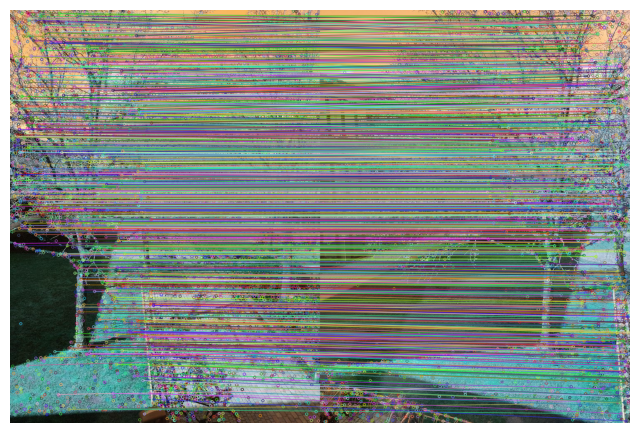

best_H:
[[-2.29945751e-03 -3.88688820e-05  9.37143892e-01]
 [-6.20030840e-04 -2.07788361e-03  3.48926293e-01]
 [-1.31507517e-06 -5.85563456e-09 -1.33275686e-03]]


In [28]:
def RANSAC_HOMOGRAPHY_MATRIX(
    im1: np.array, im2: np.array, iterations: int, threshold: float, plot: bool = False
):
    """
    Runs RANSAC for a number of iterations to find the best model with the most inliers
    and obtain an estimated homography matrix based on inliers.

    Args:
        im1 (np.array): first image
        im2 (np.array): second image
        iterations (int): number of iterations to run RANSAC
        threshold (float): threshold to determine whether a point is an inlier or outlier
        plot (bool): whether to visualize inlier matches

    Returns:
        best_H (np.array): An estimate of homography matrix based on best inliers
        best_inliers (np.array): Inliers of best homography (M, 2, 2)
    """
    most_inliers = 0
    best_inliers = None
    best_inlier_idxs = []
    best_H = None
    matches, kp1, kp2 = find_features(im1, im2)
    im1_matches = np.float32([kp1[m.queryIdx].pt for m in matches])  # Nx2
    im2_matches = np.float32([kp2[m.trainIdx].pt for m in matches])  # Nx2

    for _ in range(iterations):
        sampled_idx = np.random.choice(len(im1_matches), 4, replace=False)
        im1_samples = im1_matches[sampled_idx]  # 4x2
        im2_samples = im2_matches[sampled_idx]  # 4x2
        homo = hest(im1_samples.T, im2_samples.T)  # Assuming hest expects 2xN
        homo_distances = get_homo_error_distances(
            H=homo, q1s=im1_matches.T, q2s=im2_matches.T
        )  # Assuming 2xN input
        inlier_idxs = [idx for idx, dist in enumerate(homo_distances) if dist < threshold]
        inliers = np.array([[im1_matches[idx], im2_matches[idx]] for idx in inlier_idxs])  # Mx2x2
        num_inliers = inliers.shape[0]

        if num_inliers > most_inliers:
            most_inliers = num_inliers
            best_inliers = inliers
            best_inlier_idxs = inlier_idxs
            best_H = homo

    if best_H is None:
        raise ValueError("RANSAC did not find any inliers.")

    # Refit homography using all inliers
    print(f"Best consensus of {most_inliers} out of {len(im1_matches)} points.")
    best_H = hest(best_inliers[:, 0].T, best_inliers[:, 1].T)

    if plot:
        plt.imshow(
            cv2.drawMatches(
                im1, kp1, im2, kp2, np.array(matches)[best_inlier_idxs], None
            )
        )
        plt.axis("off")
        plt.show()

    return best_H, best_inliers

# Example usage
sigma = 3
threshold = 5.99 * sigma**2
best_H, best_inliers = RANSAC_HOMOGRAPHY_MATRIX(im1, im2, iterations=200, threshold=threshold, plot=True)
print(f"best_H:\n{best_H}")

## Example code

In [29]:
def estimate_homography_ransac(kp1, des1, kp2, des2, iters=200, plot=False):
    """
    Estimate homography matrix using RANSAC.

    Args:
        kp1 (list): Keypoints of image 1
        des1 (np.array): Descriptors of image 1
        kp2 (list): Keypoints of image 2
        des2 (np.array): Descriptors of image 2

    Returns:
        best_H (np.array): Best homography matrix, shape (3,3)
        best_inliers (np.array): Inliers of best homography (M,2,2)
    """

    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)  # ascending

    # Extract matched keypoints
    im1_pts = np.float32([kp1[m.queryIdx].pt for m in matches])  # n x 2
    im2_pts = np.float32([kp2[m.trainIdx].pt for m in matches])

    # RANSAC
    best_consensus = 0
    best_inliers = None
    best_H = None

    for i in range(iters):
        # Randomly select 4 points
        idx = np.random.choice(len(im1_pts), 4, replace=False)
        q1 = im1_pts[idx]
        q2 = im2_pts[idx]

        # Estimate homography
        H = hest(q1.T, q2.T)

        # Calculate distance
        distances = Hest_dist(H, im1_pts.T, im2_pts.T)
        inliers_idx = [idx for idx, dist in enumerate(distances) if dist < threshold]
        inliers = np.array(
            [[im1_pts[idx], im2_pts[idx]] for idx in inliers_idx]
        )  # (M,2,2)
        consensus = inliers.shape[0]

        if consensus > best_consensus:
            best_inliers_idx = inliers_idx
            best_inliers = inliers
            best_consensus = consensus
            best_H = H

    if best_H is None:
        raise ValueError("RANSAC did not find any inliers.")

    # Refit homography to inliers
    print(f"Best consensus of {best_consensus} out of {len(im1_pts)} points.")
    best_H = hest(best_inliers[:, 0].T, best_inliers[:, 1].T)

    if plot:
        # Parallel lines should be expected
        plt.imshow(
            cv2.drawMatches(
                im1, kp1, im2, kp2, np.array(matches)[best_inliers_idx], None
            )
        )
        plt.axis("off")
        plt.show()

    return best_H, best_inliers

## Ex 10.4
It takes an image and a homography and returns the image warped with the homography, where
xRange and yRange specifies for which range of x and y values the image should be sampled. The
function returns the transformed version of the image, and a mask that is 1 where the image is
valid.

In [30]:
def warpImage(im, H, xRange, yRange):
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    mask = np.ones(im.shape[:2], dtype=np.uint8)*255
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(mask, H, outSize)
    return imWarp, maskWarp

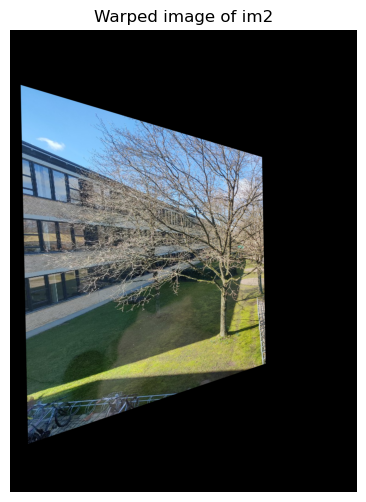

In [31]:
xRange = [-im2.shape[1], im2.shape[1]]
yRange = [int(-0.5 * im2.shape[0]), int(1.5 * im2.shape[0])]
homo_imwarp, homo_maskWarp = warpImage(im2, best_H, xRange, yRange)
plt.imshow(cv2.cvtColor(homo_imwarp, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Warped image of im2")
plt.show()

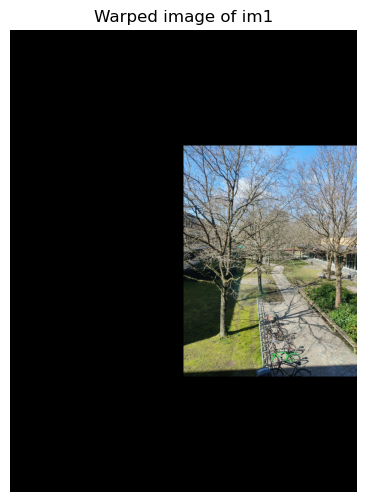

In [32]:
xRange = [-im1.shape[1], im1.shape[1]]
yRange = [int(-0.5 * im1.shape[0]), int(1.5 * im1.shape[0])]
H_eye = np.eye(3, 3)
eye_imwarp, eye_maskWarp = warpImage(im1, H_eye, 2 * xRange, 2 * yRange)
plt.imshow(cv2.cvtColor(eye_imwarp, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Warped image of im1")
plt.show()

## Ex 10.5

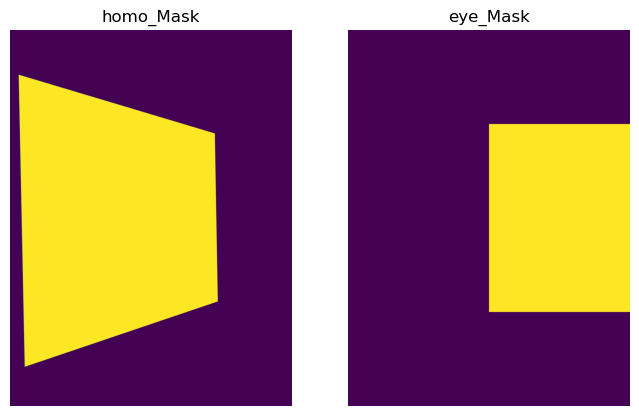

In [33]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(homo_maskWarp)
axes[0].axis("off")
axes[0].set_title("homo_Mask")
axes[1].imshow(eye_maskWarp)
axes[1].axis("off")
axes[1].set_title("eye_Mask")
plt.show()

https://numpy.org/doc/2.1/reference/generated/numpy.ma.mask_or.html

(np.float64(-0.5), np.float64(1499.5), np.float64(1999.5), np.float64(-0.5))

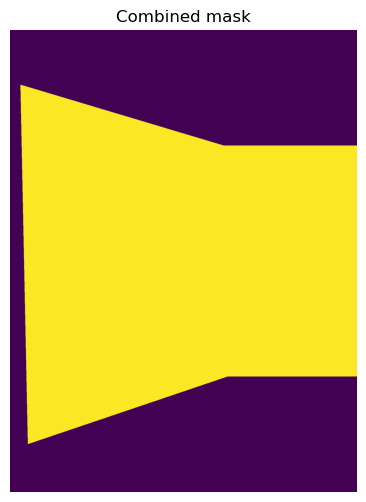

In [34]:
# Create a single mask
combined_mask = np.ma.mask_or(homo_maskWarp, eye_maskWarp)
plt.imshow(combined_mask)
plt.title("Combined mask")
plt.axis("off")

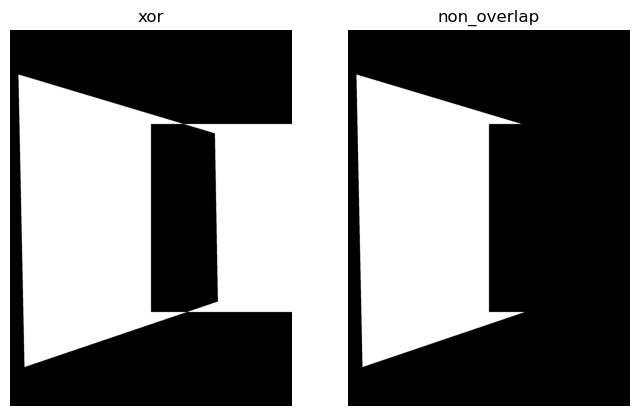

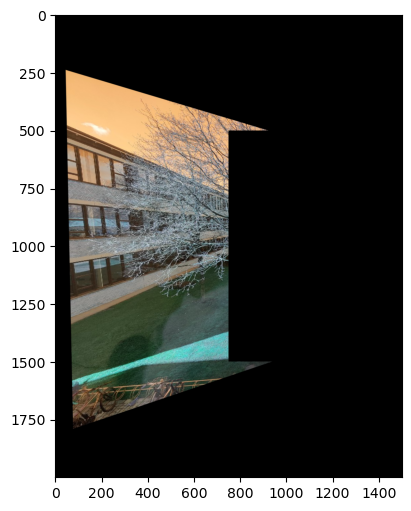

In [35]:
# xor to find overlap
xor = np.logical_xor(homo_maskWarp, eye_maskWarp)
# non overlap
non_overlap = np.logical_and(xor, homo_maskWarp)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(xor, cmap="gray")
ax[0].set_title("xor")
ax[0].axis("off")
ax[1].imshow(non_overlap, cmap="gray")
ax[1].set_title("non_overlap")
ax[1].axis("off")
plt.show()

new_dst_img = homo_imwarp.copy()
new_dst_img[non_overlap != 1] = 0
plt.imshow(new_dst_img)
plt.show()

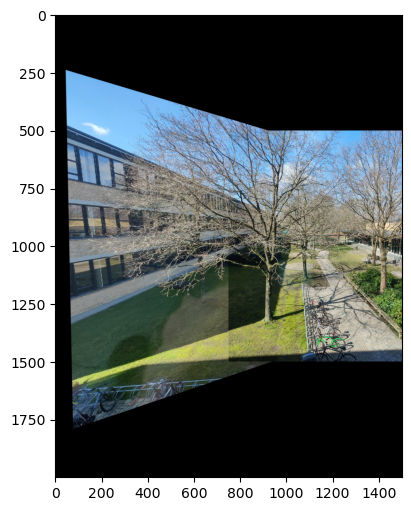

In [36]:
combined = new_dst_img + eye_imwarp
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))